In [1]:
#this notebook reproduces Fig. 4d from the paper (correlation in neural activity patterns across days)
baseDir = '/oak/stanford/groups/henderj/fwillett/speechPaperRelease_08_20'

In [2]:
#load all diagnostic blocks with attempted vocalization (not the silent speaking days)
#the "diagnostic blocks" contain 8 repetitions each of 7 words (plus a "do nothing" condition)
sessList = ['t12.2022.06.16','t12.2022.06.21','t12.2022.06.28','t12.2022.07.05','t12.2022.07.07',
           't12.2022.07.14','t12.2022.07.21','t12.2022.07.27','t12.2022.07.29','t12.2022.08.02',
           't12.2022.08.11','t12.2022.08.13']

trialDays = [78, 83, 90, 97, 99,
            106, 113, 119, 121, 125,
            134, 136]

import scipy.io
import numpy as np

allDat = []
for x in range(len(sessList)):
    dat = scipy.io.loadmat(baseDir+'/diagnosticBlocks/'+sessList[x]+'_diagnosticBlocks.mat')
    allDat.append(dat)

In [3]:
#mean-subtract the neural activity within blocks
import numpy as np
def meanSubtract(dat):
    dat['tx2'] = dat['tx2'].astype(np.float32)
    blockList = np.squeeze(np.unique(dat['blockNum']))
    if blockList.shape==():
        blockList = np.array([blockList])
    for b in blockList:
        loopIdx = np.squeeze(dat['blockNum']==b)
        dat['tx2'][loopIdx,:] -= np.mean(dat['tx2'][loopIdx,:],axis=0,keepdims=True)
    return dat

for x in range(len(sessList)):
    allDat[x] = meanSubtract(allDat[x])

In [4]:
#extract the trials of neural activity from the first block of each session
from analysis import triggeredAvg
allTrials = []

for x in range(len(allDat)):
    blockList = np.unique(allDat[x]['blockNum'])
    trlIdx = np.squeeze(allDat[x]['blockNum'][allDat[x]['goTrialEpochs'][:,0]]==blockList[0])
    featAvg, featCI, trials = triggeredAvg(allDat[x]['tx2'], allDat[x]['goTrialEpochs'][trlIdx,0], 
                                           np.squeeze(allDat[x]['trialCues'])[trlIdx], [5,30], smoothSD=0, 
                                           computeCI=False, nResamples=100)
    allTrials.append(trials)

/home/groups/henderj/fwillett/code/speechRelease_v3/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 3.2.1'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [5]:
#correlate the neural activity patterns across all 7 diagnostic words, using cross-validated correlation (see https://github.com/fwillett/cvVectorStats)
from sklearn.decomposition import PCA
from cvVectorStats import cvCorr

allTrials[0][2].shape
def unrollTrlAvg(at):
    unroll = []
    for t in range(len(at)):
        unroll.append(np.mean(at[t][:,:,0:128],axis=1))
    unroll = np.concatenate(unroll,axis=1)
    return unroll

corrMat = np.zeros([len(allTrials), len(allTrials)])
for x1 in range(len(allTrials)):
    u1 = unrollTrlAvg(allTrials[x1])

    for x2 in range(len(allTrials)):
        u2 = unrollTrlAvg(allTrials[x2])
        
        corrMat[x1, x2] = cvCorr(u1, u2)
        if x1==x2:
            corrMat[x1, x2] = 1
        

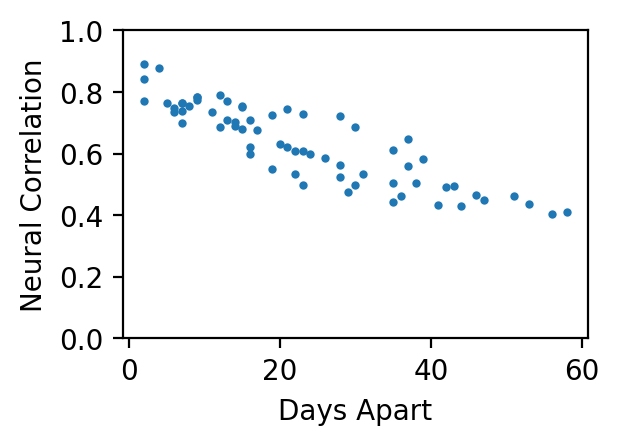

In [6]:
#summarize the correlation across time as in Fig. 4d
import matplotlib.pyplot as plt

points_x = []
points_y = []
for x1 in range(corrMat.shape[0]):
    for x2 in range(x1+1, corrMat.shape[0]):
        points_x.append(trialDays[x2]-trialDays[x1])
        points_y.append(corrMat[x1,x2])
        
plt.figure(dpi=200,figsize=(3.0,2.0))
plt.plot(points_x,points_y,'o',markersize=2)
plt.ylim([0,1.0])
plt.xlabel('Days Apart')
plt.ylabel('Neural Correlation')
plt.show()

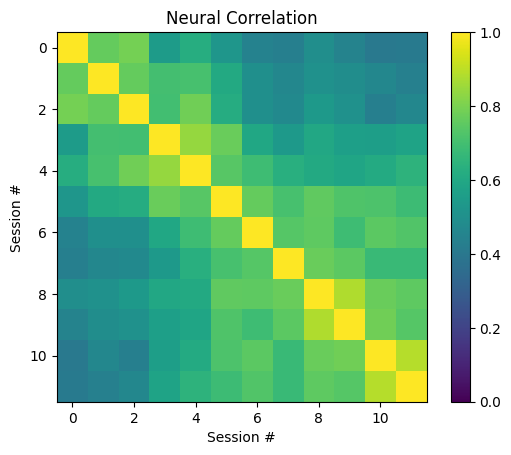

In [7]:
#plot the resulting correlation matrix - it shows that nearby days are more correlated, and there appears to be a "break" in the activity structure around session 4/5
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(corrMat, clim=[0,1])
plt.colorbar()
plt.xlabel('Session #')
plt.ylabel('Session #')
plt.title('Neural Correlation')
plt.show()